In [1]:
import numpy as np
import pandas as pd
import os, sys
import ast
import re

import copy
import scipy.optimize as optim

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,HistGradientBoostingClassifier 
#from dask_ml.xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, r2_score, mean_squared_error 
from sklearn.metrics import mean_absolute_error, plot_precision_recall_curve
from sklearn.metrics import precision_score, recall_score, accuracy_score 
from sklearn.metrics import f1_score, average_precision_score, roc_auc_score
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, LeaveOneGroupOut

/cm/shared/sw/nix/store/m6zzrz0yabsjkisw33bi1f8p5g3ryaxl-python-3.8.12-view/lib/python3.8/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [5]:
%matplotlib inline

In [6]:
all_icp = pd.read_csv('./dat/icp_transformed_scaled_after_pca.csv', index_col = [0,1])

In [7]:
no_dsRed = ['Byn_200901', 'Byn_200902', 'Byn_200903','Byn_200904',
                           'Tll_200917', 'Tll_200918','Tll_200920', 'Tll_200921', 
                           'Wg_201003', 'Wg_201005','Wg_201006','Wg_201114',
                           'Hkb_201006', 'Hkb_201110', 'Hkb_210415', 'Hkb_210416',
                       'Fkh_200906', 'Fkh_200907','Fkh_200908', 'Fkh_200909']

In [8]:
all_icp = all_icp.loc[no_dsRed]

In [9]:
all_icp['sample'] = all_icp.index.get_level_values(0)

In [10]:
all_icp['Expr'] = (all_icp['No_children'] == 2).astype(int)

In [11]:
genes = ['Byn', 'Tll', 'Wg', 'Hkb', 'Fkh']

In [12]:
sample_test = {}
for i, g in enumerate(genes):
    sample_test[g] = [np.random.choice(no_dsRed[(4*i):(4*(i+1))])]
    
#was ['Byn_200903'], ['Tll_200917'], ['Fkh_200908'], ['Wg_201005'], ['Hkb_210415']

In [13]:
#just reorder
genes = ['Byn', 'Tll', 'Fkh', 'Wg', 'Hkb']

## All cycles without weights

### Define train and test sets

In [12]:
X_train = {}
X_test = {}
y_train = {}
y_test = {}
train_index = {}
test_index = {}
#train_weights = {}
#test_weights = {}
for gene in genes:
    #print(__doc__)
    data_to_use = all_icp.query('Gene == "'+gene+'"')
    dat = data_to_use#.query('Cycle == ' + str(cycle))#.query('Z>0')
    X = np.concatenate([dat[['X', 'Y', 'Z', 'Synch_time']].values], 1)
    y = np.array(dat['Expr'].fillna(0)).reshape(-1,1)
    gene_samples = pd.unique(data_to_use['sample'])
    test_samp = sample_test[gene][0]
    print(gene, 'Test sample: ', test_samp)
    test_index[gene] = (dat['sample'].values == test_samp)
    train_index[gene] = (dat['sample'].values != test_samp)
    X_train[gene], X_test[gene] = X[train_index[gene]], X[test_index[gene]]
    y_train[gene], y_test[gene] = y[train_index[gene]], y[test_index[gene]]
    #train_weights[gene], test_weights[gene] = dat.loc[train_index[gene]]['weights'].values, dat.loc[test_index[gene]]['weights'].values

Byn Test sample:  Byn_200903
Tll Test sample:  Tll_200917
Fkh Test sample:  Fkh_200908
Wg Test sample:  Wg_201005
Hkb Test sample:  Hkb_210415


## Hyperparameter tuning

### RF

In [16]:
#experiment with 1000 trees
# Maximum number of levels in tree
rf_max_depth = [None]+[int(x) for x in np.linspace(10, 50, 10)]

# Minimal samples per leaf
rf_min_samples_leaf = [int(x) for x in np.linspace(1, 50, 10)]

# Max features
rf_max_features = [1,2,3,4]

#rf_class_weight = [{0:1, 1:p} for p in np.arange(1,4,0.5)]

# Create the grid
rf_grid = { 'max_depth': rf_max_depth,
            'min_samples_leaf': rf_min_samples_leaf,
            'max_features': rf_max_features}

In [ ]:
rf_hpt_res = {}
rf_best_params = {}
rf_best_score = {}
rf_random = {}
for gene in genes:
    #print(__doc__)
    data_to_use = all_icp.query('Gene == "'+gene+'"')
    dat = data_to_use#.query('Cycle == ' + str(cycle))#.query('Z>0')
    
    test_samp = sample_test[gene]
    print(gene, 'Test sample: ', test_samp)
    train_index = (dat['sample'].values != test_samp)
    groups = pd.factorize(dat['sample'].values[train_index])[0]
    logo = LeaveOneGroupOut()
    # Create the model to be tuned
    rf_base = RandomForestClassifier(n_estimators = 1000, n_jobs = 64)#, class_weight = "balanced")
    print('Randomized search')

    # Create the random search Random Forest
    rf_random[gene] = RandomizedSearchCV(estimator = rf_base, 
                                    scoring = ['precision', 'recall', 'accuracy', 
                                               'f1', 'average_precision', 'roc_auc'],
                                   refit = 'average_precision',
                                    param_distributions = rf_grid, 
                                    n_iter = 200, 
                                         error_score='raise',
                                    cv = logo.split(X_train[gene], 
                                                    np.ravel(y_train[gene]),
                                                    groups=groups),
                                    verbose = 2, 
                                    random_state = 420,
                                    
                                n_jobs = 64)

    # Fit the random search model
    rf_random[gene].fit(X_train[gene], np.ravel(y_train[gene]))
    print('Done')
    rf_hpt_res[gene] = rf_random[gene].cv_results_
    rf_best_params[gene] = rf_random[gene].best_params_
    rf_best_score[gene] = rf_random[gene].best_score_
    # Get the optimal parameters
    print(rf_random[gene].best_params_, rf_random[gene].best_score_)

In [21]:
import pickle
for gene in genes:
    f = open('./results/'+gene+'/RF_classification_CV_results_all_cycles.p', 'wb')
    pickle.dump(rf_hpt_res[gene], f)
    f.close()
    f = open('./results/'+gene+'/RF_classification_best_params_all_cycles.p', 'wb')
    pickle.dump(rf_best_params[gene], f)
    f.close() 
    f = open('./results/'+gene+'/RF_classification_best_score_all_cycles.p', 'wb')
    pickle.dump(rf_best_score[gene], f)
    f.close()        

In [23]:
for g in genes:
    print(g, rf_best_params[g])

Byn {'min_samples_leaf': 39, 'max_features': 2, 'max_depth': 10}
Tll {'min_samples_leaf': 44, 'max_features': 2, 'max_depth': None}
Fkh {'min_samples_leaf': 50, 'max_features': 2, 'max_depth': 41}
Wg {'min_samples_leaf': 39, 'max_features': 1, 'max_depth': 14}
Hkb {'min_samples_leaf': 44, 'max_features': 2, 'max_depth': 50}


## Process results

In [24]:
import pickle
rf_hpt_res = {}
rf_best_params = {}
rf_best_score = {}
for gene in genes:
    f = open('./results/'+gene+'/RF_classification_CV_results_all_cycles.p', 'rb')
    rf_hpt_res[gene] = pickle.load(f)
    f.close()
    f = open('./results/'+gene+'/RF_classification_best_params_all_cycles.p', 'rb')
    rf_best_params[gene] = pickle.load(f)
    f.close()
    f = open('./results/'+gene+'/RF_classification_best_score_all_cycles.p', 'rb')
    rf_best_score[gene] = pickle.load(f)
    f.close()

In [133]:
rf_best = pd.DataFrame(rf_best_params)
rf_best.to_csv('./results/classification_comparisons/Classification_RF_winners_all_cycles.csv')

In [167]:
rf_final = {}
for gene in genes:
    rf_final[gene] = RandomForestClassifier(n_estimators = 1000, 
                                           min_samples_leaf = rf_best_params[gene]['min_samples_leaf'],
                                           max_features = rf_best_params[gene]['max_features'], 
                                           max_depth = rf_best_params[gene]['max_depth'],
                                           n_jobs = -1)
    rf_final[gene].fit(X_train[gene], y_train[gene])

<ipython-input-167-8861681b0a10>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_final[gene].fit(X_train[gene], y_train[gene])
<ipython-input-167-8861681b0a10>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_final[gene].fit(X_train[gene], y_train[gene])
<ipython-input-167-8861681b0a10>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_final[gene].fit(X_train[gene], y_train[gene])
<ipython-input-167-8861681b0a10>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_final[gene].fit(X_train[gene], y_train[gene])
<ipython-input-167-8861681b0a10>

In [113]:
# Define a function that compares all final models
def final_test_comparison(models, test_features, test_labels, test_weights = None):
    scores = pd.DataFrame()
    for model in models:
        predictions = model.predict(test_features)
        print(predictions)
        pr = round(precision_score(test_labels, predictions), 4)
        rec = round(recall_score(test_labels, predictions), 4)
        acc = round(accuracy_score(test_labels, predictions), 4)
        f1 = round(f1_score(test_labels, predictions), 4)
        PRauc = round(average_precision_score(test_labels, model.predict_proba(test_features)[:,1]), 4)
        ROCauc = round(roc_auc_score(test_labels, model.predict_proba(test_features)[:,1]), 4)
        if test_weights is None:
            scores[str(model)] = [pr, rec, acc, f1, PRauc, ROCauc]
    if test_weights is None:
        scores.index = ['precision', 'recall', 'accuracy', 
                        'f1', 'average_precision', 'roc_auc']#, 'Accuracy']
    return scores


In [94]:
final_validation_PRauc = pd.DataFrame(pd.Series(rf_best_score)).T
final_validation_PRauc.index = ['PRauc']

In [18]:
# final_scores = {}
# for gene in genes:    
#     final_scores[gene.lower()] = final_test_comparison([rf_final[gene]], X_test[gene], y_test[gene])#, test_weights = test_weights[gene])

#     final_scores[gene.lower()].columns  = ['Random Forest']

In [19]:
# all_final = pd.concat(final_scores,1)

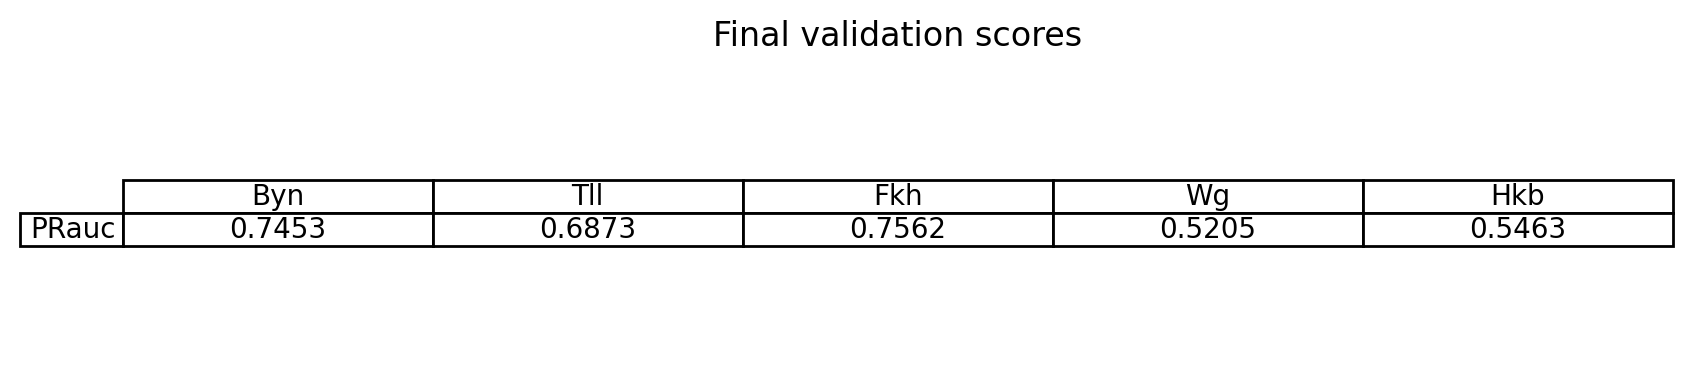

In [118]:
plt.figure(figsize = (10,2), dpi = 200)
plt.title('Final validation scores')
plt.axis('off')
plt.table(cellText=np.round(final_validation_PRauc.values, 4),
          rowLabels=final_validation_PRauc.index,
          colLabels=final_validation_PRauc.columns,
         loc = 'center',
         cellLoc = 'center')
plt.savefig('./results/Final_validation_scores_classification.png')

### GB

In [129]:
# Number of trees to be used
xgb_n_estimators = [1000]#[int(x) for x in np.linspace(50, 1000, 10)]

# Maximum number of levels in tree
xgb_max_depth = [None]+[int(x) for x in np.linspace(1, 10, 10)]

# Minimal samples per leaf
xgb_min_samples_leaf = [int(x) for x in np.linspace(2, 50, 10)]

# Learning rate
xgb_eta = [x for x in np.linspace(0.05, 0.2, 5)]

# Learning objective used
xgb_objective = ['binary_crossentropy']


# Create the grid
xgb_grid = {
            'max_depth': xgb_max_depth,
            'min_samples_leaf': xgb_min_samples_leaf,
            'learning_rate': xgb_eta,
            'loss': xgb_objective}

In [130]:
#cycle = 14
xgb_random = {}
xgb_hpt_res = {}
xgb_best_params = {}
xgb_best_score = {}
for gene in genes:
    #print(__doc__)
    data_to_use = all_icp.query('Gene == "'+gene+'"')
    dat = data_to_use#.query('Cycle == ' + str(cycle))#.query('Z>0')

    test_samp = sample_test[gene]
    print(gene, 'Test sample: ', test_samp)
    train_index = (dat['sample'].values != test_samp)
    groups = pd.factorize(dat['sample'].values[train_index])[0]
    logo = LeaveOneGroupOut()
    # Create the model to be tuned
    xgb_base = HistGradientBoostingClassifier(max_iter=1000)
    print('Randomized search')

    # Create the random search Random Forest
    xgb_random[gene] = RandomizedSearchCV(estimator = xgb_base, 
                                    param_distributions = xgb_grid, 
                                          scoring = ['precision', 'recall', 'accuracy', 
                                               'f1', 'average_precision', 'roc_auc'],
                                   refit = 'average_precision',
                                    n_iter = 200, 
                                    cv = logo.split(X_train[gene], 
                                                    y_train[gene],
                                                    groups=groups),
                                    verbose = 2, 
                                    random_state = 420, n_jobs = -1)

    # Fit the random search model
    xgb_random[gene].fit(X_train[gene], y_train[gene])
    print('Done')
    xgb_hpt_res[gene] = xgb_random[gene].cv_results_
    xgb_best_params[gene] = xgb_random[gene].best_params_
    xgb_best_score[gene] = xgb_random[gene].best_score_
    # Get the optimal parameters
    print(xgb_random[gene].best_params_, xgb_random[gene].best_score_)

Byn Test sample:  ['Byn_200903']
Randomized search
Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.5min finished
/cm/shared/sw/nix/store/b118p164vsfg67989zbp3a1z8dz7gq6z-python3-3.8.8-env/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Done
{'min_samples_leaf': 39, 'max_depth': 3, 'loss': 'binary_crossentropy', 'learning_rate': 0.08750000000000001} 0.7472790082278574
Tll Test sample:  ['Tll_200917']
Randomized search
Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.0min finished
/cm/shared/sw/nix/store/b118p164vsfg67989zbp3a1z8dz7gq6z-python3-3.8.8-env/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Done
{'min_samples_leaf': 23, 'max_depth': 5, 'loss': 'binary_crossentropy', 'learning_rate': 0.08750000000000001} 0.6924211762668264
Fkh Test sample:  ['Fkh_200908']
Randomized search
Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.0min finished
/cm/shared/sw/nix/store/b118p164vsfg67989zbp3a1z8dz7gq6z-python3-3.8.8-env/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Done
{'min_samples_leaf': 18, 'max_depth': 6, 'loss': 'binary_crossentropy', 'learning_rate': 0.08750000000000001} 0.7603410761115471
Wg Test sample:  ['Wg_201005']
Randomized search
Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.3min finished
/cm/shared/sw/nix/store/b118p164vsfg67989zbp3a1z8dz7gq6z-python3-3.8.8-env/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Done
{'min_samples_leaf': 12, 'max_depth': 3, 'loss': 'binary_crossentropy', 'learning_rate': 0.05} 0.5123785295857353
Hkb Test sample:  ['Hkb_210415']
Randomized search
Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  1.1min finished
/cm/shared/sw/nix/store/b118p164vsfg67989zbp3a1z8dz7gq6z-python3-3.8.8-env/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Done
{'min_samples_leaf': 44, 'max_depth': 2, 'loss': 'binary_crossentropy', 'learning_rate': 0.16250000000000003} 0.5472662009875157


In [131]:
import pickle
for gene in genes:
    f = open('./results/'+gene+'/GradientBoost_classification_CV_results_all_cycles.p', 'wb')
    pickle.dump(xgb_hpt_res[gene], f)
    f.close()
    f = open('./results/'+gene+'/GradientBoost_classification_best_params_all_cycles.p', 'wb')
    pickle.dump(xgb_best_params[gene], f)
    f.close() 
    f = open('./results/'+gene+'/GradientBoost_classification_best_score_all_cycles.p', 'wb')
    pickle.dump(xgb_best_score[gene], f)
    f.close()        

## Process results

In [137]:
import pickle
# rf_hpt_res = {}
# rf_best_params = {}
# rf_best_score = {}
for gene in genes:
    f = open('./results/'+gene+'/GradientBoost_classification_CV_results_all_cycles.p', 'rb')
    xgb_hpt_res[gene] = pickle.load(f)
    f.close()
    f = open('./results/'+gene+'/GradientBoost_classification_best_params_all_cycles.p', 'rb')
    xgb_best_params[gene] = pickle.load(f)
    f.close()
    f = open('./results/'+gene+'/GradientBoost_classification_best_score_all_cycles.p', 'rb')
    xgb_best_score[gene] = pickle.load(f)
    f.close()

In [138]:
xgb_best = pd.DataFrame(xgb_best_params)
xgb_best.to_csv('./results/classification_comparisons/GradientBoost_RF_winners_all_cycles.csv')

In [ ]:
xgb_final = {}
for gene in genes:
    xgb_final[gene] =  HistGradientBoostingClassifier(max_iter=1000, 
                                           min_samples_leaf = xgb_best_params[gene]['min_samples_leaf'],
                                           learning_rate = xgb_best_params[gene]['learning_rate'],
                                           max_depth = xgb_best_params[gene]['max_depth'],
                                           loss =           xgb_best_params[gene]['loss'],)
    xgb_final[gene].fit(X_train[gene], y_train[gene])

/cm/shared/sw/nix/store/b118p164vsfg67989zbp3a1z8dz7gq6z-python3-3.8.8-env/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/cm/shared/sw/nix/store/b118p164vsfg67989zbp3a1z8dz7gq6z-python3-3.8.8-env/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/cm/shared/sw/nix/store/b118p164vsfg67989zbp3a1z8dz7gq6z-python3-3.8.8-env/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/cm/shared/sw/nix/store/b118p164vsfg67989zbp3a1z8dz7gq6z-python3

In [146]:
final_validation_PRauc = pd.DataFrame(pd.Series(xgb_best_score)).T
final_validation_PRauc.index = ['PRauc']

In [20]:
# final_scores = {}
# for gene in genes:    
#     # Call the comparison function with the three final models
# #    final_scores[gene] = final_comparison([knn_final[gene], rf_final[gene], xgb_final[gene]], X_test[gene], y_test[gene])
#     final_scores[gene.lower()] = final_test_comparison([xgb_final[gene]], X_test[gene], y_test[gene])#, test_weights = test_weights[gene])


#     # Adjust the column headers
#     final_scores[gene.lower()].columns  = ['GradientBoost']
#     #print(final_scores[gene])

In [21]:
# all_final = pd.concat(final_scores,1)

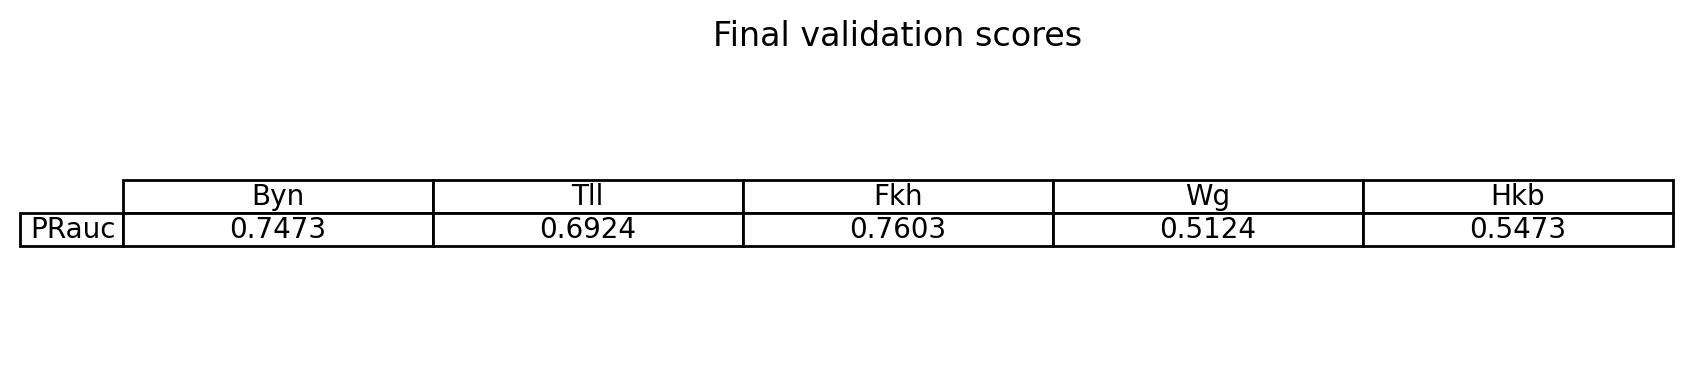

In [150]:
plt.figure(figsize = (10,2), dpi = 200)
plt.title('Final validation scores')
plt.axis('off')
plt.table(cellText=np.round(final_validation_PRauc.values, 4),
          rowLabels=final_validation_PRauc.index,
          colLabels=final_validation_PRauc.columns,
         loc = 'center',
         cellLoc = 'center')
plt.savefig('./results/classification_comparisons/GB/Final_validation_scores_classification.png')

### KNN

In [169]:
knn_n_neighbors = [int(x) for x in np.linspace(5, 300, 30)]

knn_weights = ['uniform', 'distance']

knn_p = [1,2]


# Create the grid
knn_grid = {'n_neighbors': knn_n_neighbors,
            'weights': knn_weights,
            'p': knn_p
}

In [ ]:
#cycle = 14
knn_random = {}
knn_hpt_res = {}
knn_best_params = {}
knn_best_score = {}
for gene in genes:
    #print(__doc__)
    data_to_use = all_icp.query('Gene == "'+gene+'"')
    dat = data_to_use#.query('Cycle == ' + str(cycle))#.query('Z>0')
    test_samp = sample_test[gene]
    print(gene, 'Test sample: ', test_samp)
    train_index = (dat['sample'].values != test_samp)
    groups = pd.factorize(dat['sample'].values[train_index])[0]
    logo = LeaveOneGroupOut()
    # Create the model to be tuned
    knn_base = KNeighborsClassifier(n_jobs = -1)
    print('Randomized search')

    # Create the random search Random Forest
    knn_random[gene] = RandomizedSearchCV(estimator = knn_base, 
                                    param_distributions = knn_grid, 
                                          scoring = ['precision', 'recall', 'accuracy', 
                                               'f1', 'average_precision', 'roc_auc'],
                                   refit = 'average_precision',
                                    n_iter = 200, 
                                    cv = logo.split(X_train[gene], 
                                                    y_train[gene],
                                                    groups=groups),
                                    verbose = 2, 
                                    random_state = 420, n_jobs = -1)

    # Fit the random search model
    knn_random[gene].fit(X_train[gene], y_train[gene])
    print('Done')
    knn_hpt_res[gene] = knn_random[gene].cv_results_
    knn_best_params[gene] = knn_random[gene].best_params_
    knn_best_score[gene] = knn_random[gene].best_score_
    # Get the optimal parameters
    print(knn_random[gene].best_params_, knn_random[gene].best_score_)

Byn Test sample:  ['Byn_200903']
Randomized search
Fitting 3 folds for each of 120 candidates, totalling 360 fits


/cm/shared/sw/nix/store/b118p164vsfg67989zbp3a1z8dz7gq6z-python3-3.8.8-env/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 120 is smaller than n_iter=200. Running 120 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
/cm/shared/sw/nix/store/b118p164vsfg67989zbp3a1z8dz7gq6z-python3-3.8.8-env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done 286 out of 360 | elapsed:  3.8min remaining:   59.8s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  4.8min finished
/cm/shared/sw/nix/store/b118p164vsfg67989zbp3a1z8dz7gq6z-python3-3.8.8-env/lib/python3.8/site-packages/sklearn/model_selection/_search.py:765: DataConversion

Done
{'weights': 'distance', 'p': 1, 'n_neighbors': 116} 0.728070668385814
Tll Test sample:  ['Tll_200917']
Randomized search
Fitting 3 folds for each of 120 candidates, totalling 360 fits


/cm/shared/sw/nix/store/b118p164vsfg67989zbp3a1z8dz7gq6z-python3-3.8.8-env/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 120 is smaller than n_iter=200. Running 120 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
/cm/shared/sw/nix/store/b118p164vsfg67989zbp3a1z8dz7gq6z-python3-3.8.8-env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [172]:
import pickle
for gene in genes:
    f = open('./results/'+gene+'/KNN_classification_CV_results_all_cycles.p', 'wb')
    pickle.dump(knn_hpt_res[gene], f)
    f.close()
    f = open('./results/'+gene+'/KNN_classification_best_params_all_cycles.p', 'wb')
    pickle.dump(knn_best_params[gene], f)
    f.close() 
    f = open('./results/'+gene+'/KNN_classification_best_score_all_cycles.p', 'wb')
    pickle.dump(knn_best_score[gene], f)
    f.close()        

## Process results

In [137]:
import pickle
knn_hpt_res = {}
knn_best_params = {}
knn_best_score = {}
for gene in genes:
    f = open('./results/'+gene+'/KNN_classification_CV_results_all_cycles.p', 'rb')
    knn_hpt_res[gene] = pickle.load(f)
    f.close()
    f = open('./results/'+gene+'/KNN_classification_best_params_all_cycles.p', 'rb')
    knn_best_params[gene] = pickle.load(f)
    f.close()
    f = open('./results/'+gene+'/KNN_classification_best_score_all_cycles.p', 'rb')
    knn_best_score[gene] = pickle.load(f)
    f.close()

In [175]:
knn_best = pd.DataFrame(knn_best_params)
knn_best.to_csv('./results/classification_comparisons/KNN_RF_winners_all_cycles.csv')

In [176]:
knn_final = {}
for gene in genes:
    knn_final[gene] =  KNeighborsClassifier(n_neighbors = knn_best_params[gene]['n_neighbors'],
                                           weights = knn_best_params[gene]['weights'],
                                           p = knn_best_params[gene]['p'],
                                           n_jobs = -1)
    knn_final[gene].fit(X_train[gene], y_train[gene])

<ipython-input-176-582a6a5eaf6c>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn_final[gene].fit(X_train[gene], y_train[gene])
<ipython-input-176-582a6a5eaf6c>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn_final[gene].fit(X_train[gene], y_train[gene])
<ipython-input-176-582a6a5eaf6c>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn_final[gene].fit(X_train[gene], y_train[gene])
<ipython-input-176-582a6a5eaf6c>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  knn_final[gene].fit(X_train[gene], y_train[gene])
<ipython-input-176-582a6

In [177]:
final_validation_PRauc = pd.DataFrame(pd.Series(knn_best_score)).T
final_validation_PRauc.index = ['PRauc']

In [24]:
# final_scores = {}
# for gene in genes:    
#     # Call the comparison function with the three final models
# #    final_scores[gene] = final_comparison([knn_final[gene], rf_final[gene], xgb_final[gene]], X_test[gene], y_test[gene])
#     final_scores[gene.lower()] = final_test_comparison([knn_final[gene]], X_test[gene], y_test[gene])#, test_weights = test_weights[gene])


#     # Adjust the column headers
#     final_scores[gene.lower()].columns  = ['KNN']
#     #print(final_scores[gene])

In [25]:
# all_final = pd.concat(final_scores,1)

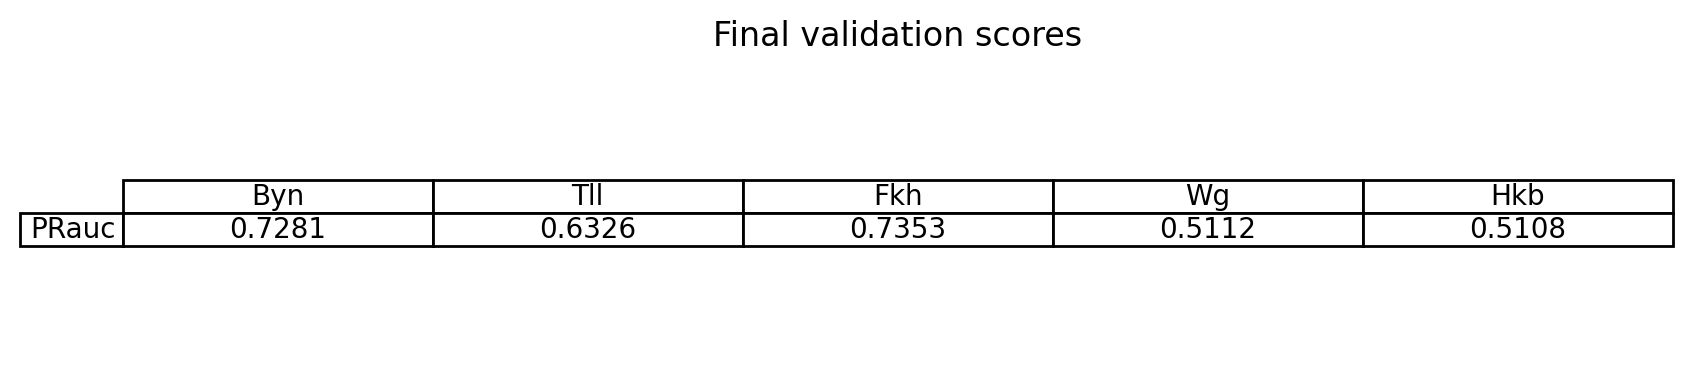

In [181]:
plt.figure(figsize = (10,2), dpi = 200)
plt.title('Final validation scores')
plt.axis('off')
plt.table(cellText=np.round(final_validation_PRauc.values, 4),
          rowLabels=final_validation_PRauc.index,
          colLabels=final_validation_PRauc.columns,
         loc = 'center',
         cellLoc = 'center')
plt.savefig('./results/classification_comparisons/KNN/Final_validation_scores_classification.png')

## Final comparison

In [65]:
import pickle
xgb_hpt_res = {}
xgb_best_params = {}
xgb_best_score = {}
for gene in genes:
    f = open('./results/'+gene+'/GradientBoost_classification_CV_results_all_cycles.p', 'rb')
    xgb_hpt_res[gene] = pickle.load(f)
    f.close()
    f = open('./results/'+gene+'/GradientBoost_classification_best_params_all_cycles.p', 'rb')
    xgb_best_params[gene] = pickle.load(f)
    f.close()
    f = open('./results/'+gene+'/GradientBoost_classification_best_score_all_cycles.p', 'rb')
    xgb_best_score[gene] = pickle.load(f)
    f.close()

knn_hpt_res = {}
knn_best_params = {}
knn_best_score = {}
for gene in genes:
    f = open('./results/'+gene+'/KNN_classification_CV_results_all_cycles.p', 'rb')
    knn_hpt_res[gene] = pickle.load(f)
    f.close()
    f = open('./results/'+gene+'/KNN_classification_best_params_all_cycles.p', 'rb')
    knn_best_params[gene] = pickle.load(f)
    f.close()
    f = open('./results/'+gene+'/KNN_classification_best_score_all_cycles.p', 'rb')
    knn_best_score[gene] = pickle.load(f)
    f.close()

import pickle
rf_hpt_res = {}
rf_best_params = {}
rf_best_score = {}
for gene in genes:
    f = open('./results/'+gene+'/RF_classification_CV_results_all_cycles.p', 'rb')
    rf_hpt_res[gene] = pickle.load(f)
    f.close()
    f = open('./results/'+gene+'/RF_classification_best_params_all_cycles.p', 'rb')
    rf_best_params[gene] = pickle.load(f)
    f.close()
    f = open('./results/'+gene+'/RF_classification_best_score_all_cycles.p', 'rb')
    rf_best_score[gene] = pickle.load(f)
    f.close()

In [14]:
# generate tables over folds

In [15]:
knn_final = {}
rf_final = {}
xgb_final = {}
for gene in genes:
    knn_final[gene] = KNeighborsClassifier(n_neighbors = knn_best_params[gene]['n_neighbors'],
                                           weights = knn_best_params[gene]['weights'],
                                           p = knn_best_params[gene]['p'],
                                           n_jobs = -1)
    rf_final[gene] = RandomForestClassifier(n_estimators = 1000, 
                                           min_samples_leaf = rf_best_params[gene]['min_samples_leaf'],
                                           max_features = rf_best_params[gene]['max_features'], 
                                           max_depth = rf_best_params[gene]['max_depth'],
                                           n_jobs = -1)
    xgb_final[gene] = HistGradientBoostingClassifier(max_iter=1000, 
                                           min_samples_leaf = xgb_best_params[gene]['min_samples_leaf'],
                                           learning_rate = xgb_best_params[gene]['learning_rate'],
                                           max_depth = xgb_best_params[gene]['max_depth'],
                                           loss = xgb_best_params[gene]['loss'])

In [63]:
from scikitplot.plotters import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.base import clone
def my_plot_prc(clf, X, y,
                                        title='Precision-Recall Curve',
                                        do_cv=True, cv=None, shuffle=True,
                                        random_state=None,
                                        i_method = 0,
                                        num_methods = 3,
                j = 2,
                                        curves=('micro', 'each_class'),
                                        ax=None, figsize=None,
                color = 'blue',
                                        cmap='nipy_spectral',
                                        title_fontsize="large",
                                        text_fontsize="medium", method_name = None,
               print_scores = True):
    y = np.array(y)

    if not hasattr(clf, 'predict_proba'):
        raise TypeError('"predict_proba" method not in classifier. '
                        'Cannot calculate Precision-Recall Curve.')

    if not do_cv:
        probas = clf.predict_proba(X)
        y_true = y

    else:
        if cv is None:
            cv = StratifiedKFold(shuffle=shuffle, random_state=random_state)
        elif isinstance(cv, int):
            cv = StratifiedKFold(n_splits=cv, shuffle=shuffle,
                                 random_state=random_state)
        else:
            pass

        clf_clone = clone(clf)

        preds_list = []
        trues_list = []
        for train_index, test_index in cv:
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            clf_clone.fit(X_train, y_train)
            preds = clf_clone.predict_proba(X_test)
            preds_list.append(preds)
            trues_list.append(y_test)
            if print_scores:
                print(average_precision_score(y_test, preds[:,1]))
        probas = np.concatenate(preds_list, axis=0)
        y_true = np.concatenate(trues_list)


    # Compute Precision-Recall curve and area for each class
    precision, recall, thresholds = precision_recall_curve(y_true, probas[:,1])
    average_precision = average_precision_score(y_true, probas[:,1])
    print(average_precision)
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    ax.set_title(title, fontsize=title_fontsize)
    
    #color = plt.cm.get_cmap(cmap)(float(i_method) / num_methods)
    ax.plot(recall, precision, lw=2,
            label=method_name+' (area = {0:0.3f})'.format(
                                             average_precision),
            color=color)

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    if j>1:
        ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc='best', fontsize=text_fontsize)
    return ax
#     ax = plot_precision_recall_curve(y_true, probas, title=title,
#                                               curves=curves, ax=ax,
#                                               figsize=figsize, cmap=cmap,
#                                               title_fontsize=title_fontsize,
#                                               text_fontsize=text_fontsize)


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


Byn Test sample:  ['Byn_200903']


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.7202597786295627


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.7724463613523204


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.6915058651755588
0.7155918962351103


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.7429744137870045


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.794551853432667


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.7009011831816571
0.7274956935428402


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.7417439977106598


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.772652845820846


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.7208116789255581
0.7194660844038148


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


Tll Test sample:  ['Tll_200917']


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.6397601652974318


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.6887219147666559


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.5694278045222168
0.6195963503593135


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.6932782078799771


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.7251983949547335


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.6486013635213987
0.6721078633254728


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.697287190102934


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.7140156794386836


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.6491278617686894
0.6730803871965173


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


Fkh Test sample:  ['Fkh_200908']


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.7372991543676051


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.7138422676912547


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.7548966541670676
0.7317803225962656


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.7532403134434772


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.6778629105413254


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.792165510516853
0.7190104796412096


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.7581654675951842


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.722099038624541


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.7863765819197928
0.7463276333943755


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


Wg Test sample:  ['Wg_201005']


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.48183657216223463


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.4953510480395229


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.5562926448041751
0.49474069123622477


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.49877696509963976


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.46769239051972855


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.5461923301266789
0.48660950995684504


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.49035761268881395


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.5045630414197119


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.5642114000308834
0.5003243826478554


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


Hkb Test sample:  ['Hkb_210415']


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.5271278034424163


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.5121210194449639


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/sklearn/neighbors/_classification.py:179: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


0.49310685654067665
0.5082151787251356


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.587836341392636


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.5420241089897917


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.5008422158886949
0.5351638013969122


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.5744888349703733


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.5537881841610472


/mnt/home/mavdeeva/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.5098077554177944
0.5412723784825793


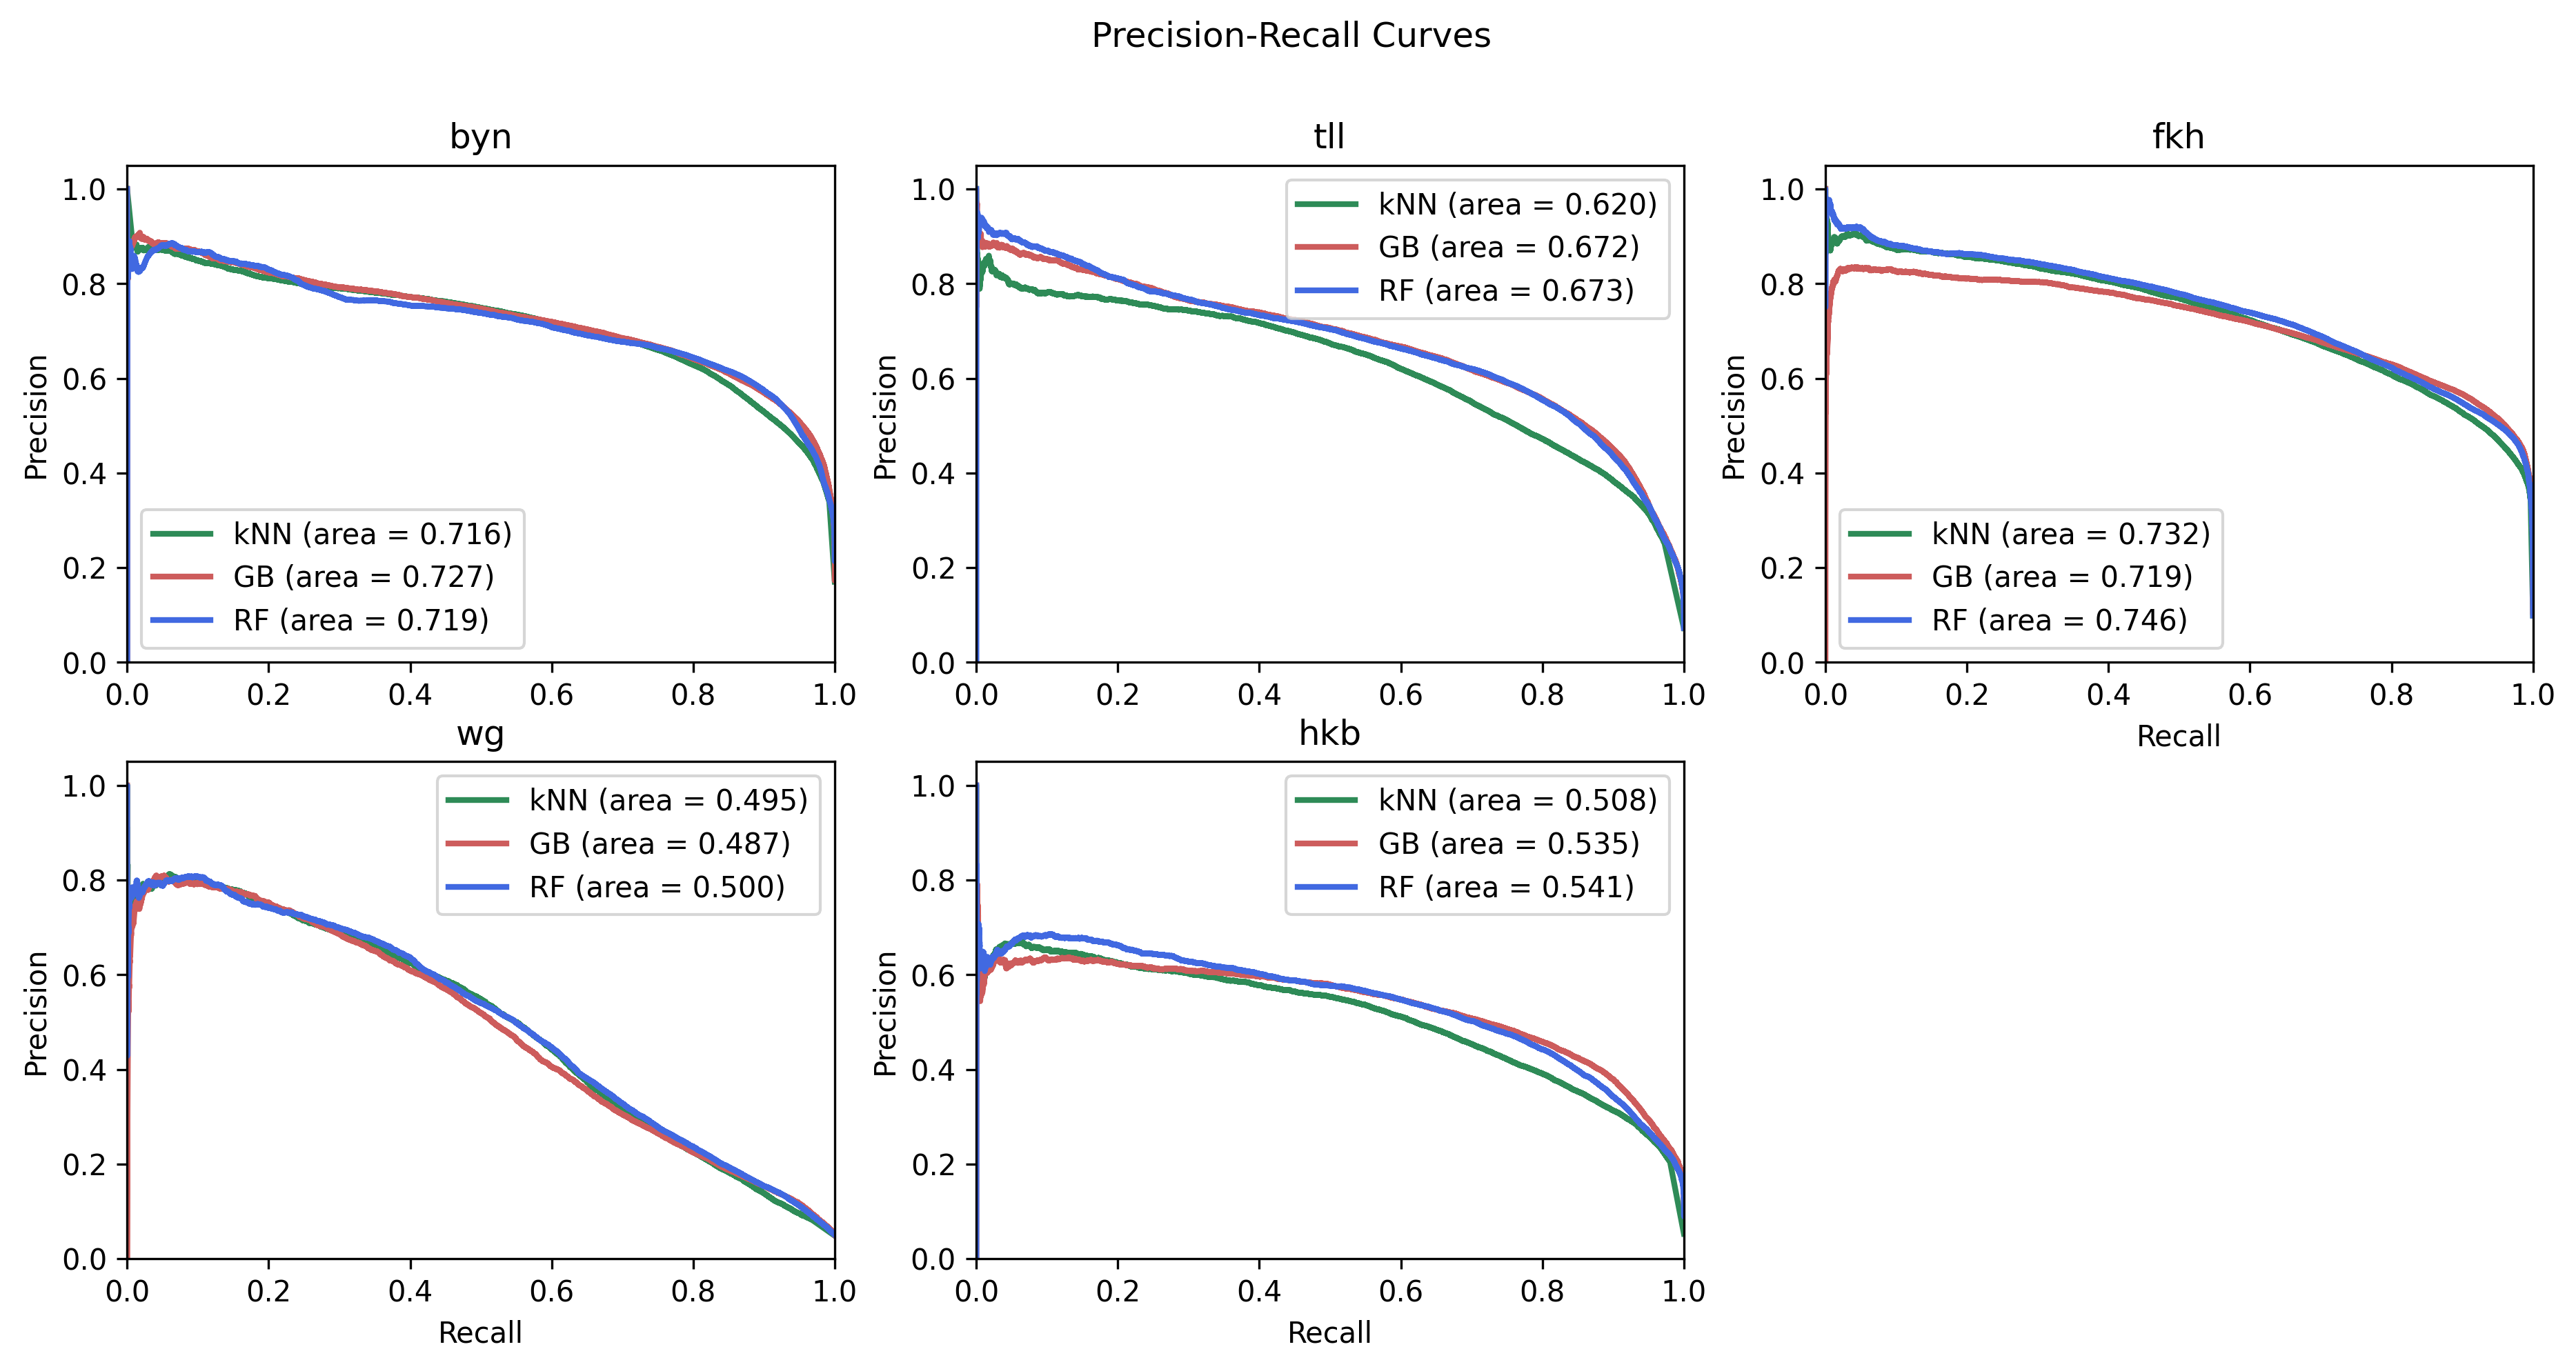

In [64]:
# generate average PR curves after cross-validation
from scikitplot.classifiers import plot_precision_recall_curve_with_cv
colors = ['seagreen', 'indianred', 'royalblue']
plt.figure(dpi = 300, figsize = (15,7))
for j,gene in enumerate(genes):
    ax = plt.subplot('23'+str(j+1))
    data_to_use = all_icp.query('Gene == "'+gene+'"')
    dat = data_to_use#.query('Cycle == ' + str(cycle))#.query('Z>0')
    test_samp = sample_test[gene]
    print(gene, 'Test sample: ', test_samp)
    train_index = (dat['sample'].values != test_samp)
    groups = pd.factorize(dat['sample'].values[train_index])[0]
    logo = LeaveOneGroupOut()
    for i,(clf, name) in enumerate(zip([knn_final[gene], xgb_final[gene], rf_final[gene]],
                                    [ 'kNN', 'GB',  'RF'])):
        my_plot_prc(clf, X_train[gene], y_train[gene],
                                                title=gene.lower(),
                                                do_cv=True, cv = logo.split(X_train[gene], 
                                                            y_train[gene],
                                                            groups=groups), 
                    shuffle=True,
                                                random_state=None,j = j,
                    i_method = i, method_name = name,color = colors[i],
                                                #curves=('micro'),
                                                ax=ax, figsize=None,
                                                cmap='nipy_spectral',
                                                title_fontsize="large",
                                                text_fontsize="medium")
plt.suptitle('Precision-Recall Curves')
plt.savefig('./results/classification_comparisons/Final_CV_precision_recall_curve_all_cycles.png', dpi = 300)
plt.savefig('./results/classification_comparisons/svgs/Final_CV_precision_recall_curve_all_cycles.svg', dpi = 300)



In [ ]:
knn_final = {}
rf_final = {}
xgb_final = {}
for gene in genes:
    knn_final[gene] = KNeighborsClassifier(n_neighbors = knn_best_params[gene]['n_neighbors'],
                                           weights = knn_best_params[gene]['weights'],
                                           p = knn_best_params[gene]['p'],
                                           n_jobs = -1)
    rf_final[gene] = RandomForestClassifier(n_estimators = 1000, 
                                           min_samples_leaf = rf_best_params[gene]['min_samples_leaf'],
                                           max_features = rf_best_params[gene]['max_features'], 
                                           max_depth = rf_best_params[gene]['max_depth'],
                                           n_jobs = -1)
    xgb_final[gene] = HistGradientBoostingClassifier(max_iter=1000, 
                                           min_samples_leaf = xgb_best_params[gene]['min_samples_leaf'],
                                           learning_rate = xgb_best_params[gene]['learning_rate'],
                                           max_depth = xgb_best_params[gene]['max_depth'],
                                           loss = xgb_best_params[gene]['loss'])
    knn_final[gene].fit(X_train[gene], y_train[gene])
    rf_final[gene].fit(X_train[gene], y_train[gene])
    xgb_final[gene].fit(X_train[gene], y_train[gene])

In [16]:
# Define a function that compares all final models
def final_comparison(models, test_features, test_labels, test_weights = None):
    scores = pd.DataFrame()
    for model in models:
        predictions = model.predict(test_features)
        print(predictions)
        pr = round(precision_score(test_labels, predictions), 4)
        rec = round(recall_score(test_labels, predictions), 4)
        acc = round(accuracy_score(test_labels, predictions), 4)
        f1 = round(f1_score(test_labels, predictions), 4)
        PRauc = round(average_precision_score(test_labels, model.predict_proba(test_features)[:,1]), 4)
        ROCauc = round(roc_auc_score(test_labels, model.predict_proba(test_features)[:,1]), 4)
#         if test_weights is not None:
#             mae_w = round(mean_absolute_error(test_labels, predictions, sample_weight = test_weights), 4)
#             mse_w = round(mean_squared_error(test_labels, predictions, sample_weight = test_weights), 4)
#             r2_w = round(r2_score(test_labels, predictions, sample_weight = test_weights), 4)            
        if test_weights is None:
            scores[str(model)] = [pr, rec, acc, f1, PRauc, ROCauc]
#         else:
#             scores[str(model)] = [mae, mse, r2, mae_w, mse_w, r2_w]#, accuracy]
    if test_weights is None:
        scores.index = ['precision', 'recall', 'accuracy', 
                        'f1', 'average_precision', 'roc_auc']#, 'Accuracy']
#     else:
#         scores.index = ['Mean Absolute Error', 'Mean Squared Error', 'R^2', 
#                         'Weighted Mean Absolute Error', 'Weighted Mean Squared Error', 'Weighted R^2']#,
#                         #'Accuracy']
    return scores



In [ ]:
final_scores = {}
for gene in genes:    
    # Call the comparison function with the three final models
    final_scores[gene] = final_comparison([knn_final[gene], rf_final[gene], xgb_final[gene]], X_test[gene], y_test[gene])
    final_scores[gene].columns  = ['KNN', 'Random Forest', 'Gradient Boosting']
    print(final_scores[gene])

In [188]:
# for gene in genes:
#     final_scores[gene] = final_scores[gene].iloc[:-1,:]

In [74]:
for gene in genes:
    final_scores[gene].to_csv('./results/'+gene+'/Final_classification_test_scores_all_cycles.csv')

In [76]:
all_final.to_csv('./results/classification_comparisons/Final_test_all_metrics_all_cycles.csv')

In [26]:
final_validation_PRauc = pd.concat([pd.concat([pd.Series(knn_best_score), pd.Series(rf_best_score)], 1), pd.Series(xgb_best_score)], 1)
final_validation_PRauc.columns = ['KNN', 'Random Forest', 'Gradient Boosting']
final_validation_PRauc.to_csv('./results/classification_comparisons/Final_validation_scores_classification_all_cycles.csv')

In [28]:
all_final = pd.concat(final_scores)

In [29]:
all_final.index.names = ['Gene', 'Metric']

In [30]:
final_test_PRauc = all_final.query('Metric == "average_precision"').droplevel(1)
final_test_PRauc.columns = ['KNN', 'Random Forest', 'Gradient Boosting']

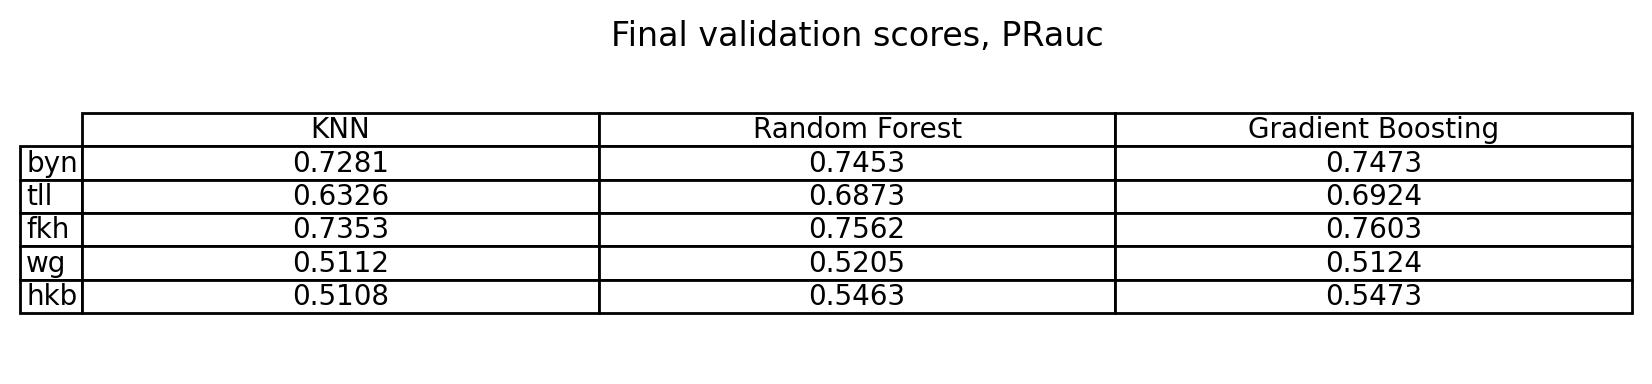

In [31]:
plt.figure(figsize = (10,2), dpi = 200)
plt.title('Final validation scores, PRauc')
plt.axis('off')
plt.table(cellText=np.round(final_validation_PRauc.values, 4),
          rowLabels=[x.lower() for x in final_validation_PRauc.index],
          colLabels=final_validation_PRauc.columns,
         loc = 'center',
         cellLoc = 'center')
plt.savefig('./results/classification_comparisons/Final_validation_PRauc_classification_all_cycles.png')
plt.savefig('./results/classification_comparisons/svgs/Final_validation_PRauc_classification_all_cycles.svg')

In [33]:
final_test_PRauc.to_csv('./results/classification_comparisons/Final_test_PRauc_classification_all_cycles.csv')

In [ ]:
plt.figure(figsize = (10,2), dpi = 200)
plt.title('Final test scores, PRauc')
plt.axis('off')
plt.table(cellText=np.round(final_test_PRauc.values, 4),
          rowLabels=[x.lower() for x in final_test_PRauc.index],
          colLabels=final_test_PRauc.columns,
         loc = 'center',
         cellLoc = 'center')
plt.savefig('./results/classification_comparisons/Final_test_PRauc_classification_all_cycles.png')
plt.savefig('./results/classification_comparisons/svgs/Final_test_PRauc_classification_all_cycles.svg')

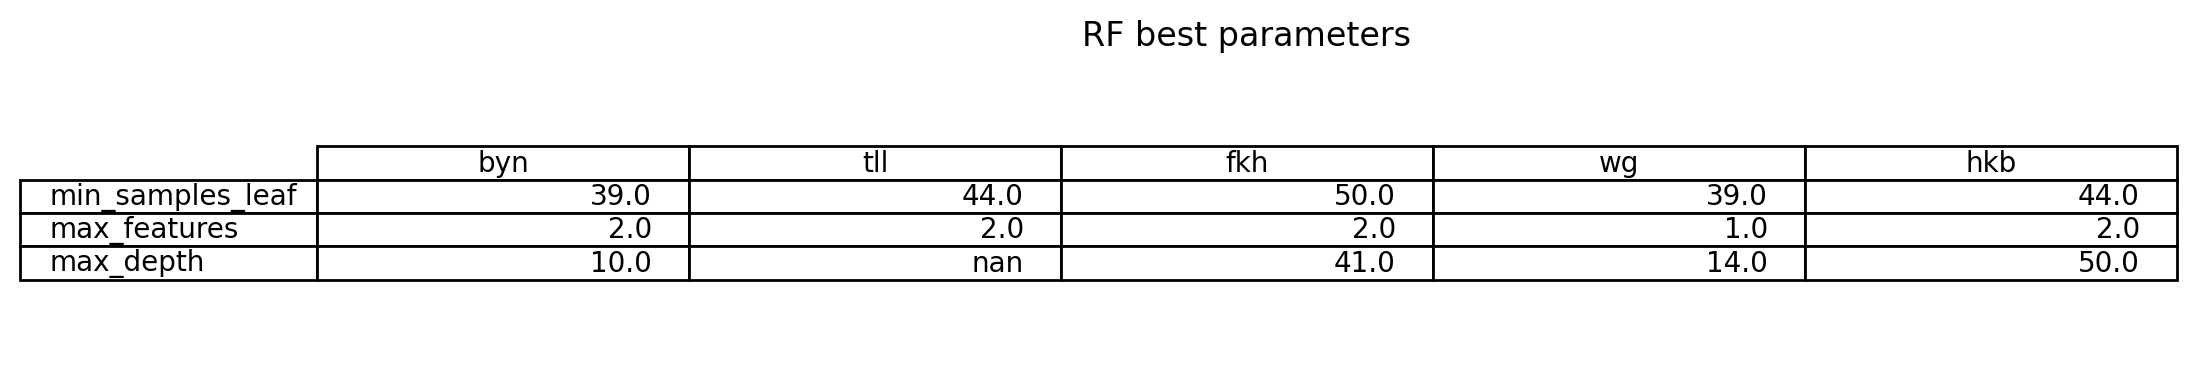

In [72]:
plt.figure(figsize = (12,2), dpi = 200)
rf_best = pd.DataFrame(rf_best_params)
plt.axis('off')
plt.table(cellText= rf_best.values,
          rowLabels=rf_best.index,
          colLabels=[x.lower() for x in rf_best.columns],
         loc = 'center')
#plt.tight_layout()
plt.title('RF best parameters')
plt.savefig('./results/classification_comparisons/RF_best_params.png')
plt.savefig('./results/classification_comparisons/svgs/RF_best_params.svg')

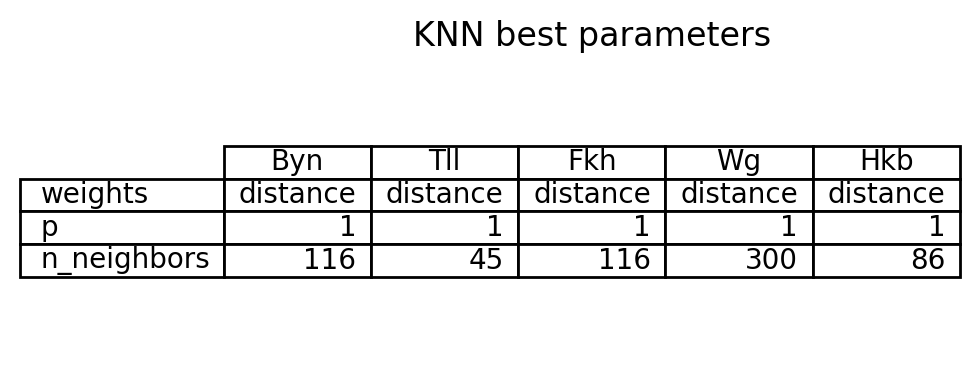

In [50]:
plt.figure(figsize = (5,2), dpi = 200)
knn_best = pd.DataFrame(knn_best_params)
plt.axis('off')
plt.table(cellText= knn_best.values,
          rowLabels=knn_best.index,
          colLabels=knn_best.columns,
         loc = 'center')
plt.title('KNN best parameters')
plt.tight_layout()
plt.savefig('./results/classification_comparisons/KNN_best_params.png')
plt.savefig('./results/classification_comparisons/svgs/KNN_best_params.svg')

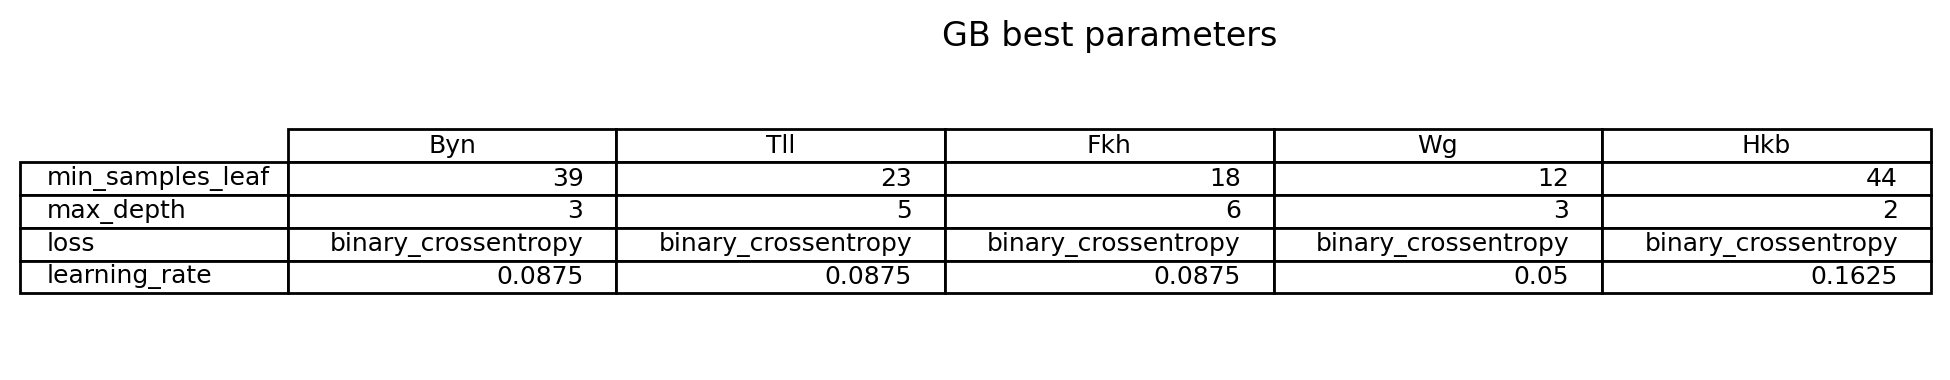

In [64]:
plt.figure(figsize = (10,2), dpi = 200)
xgb_best = pd.DataFrame(xgb_best_params).iloc[:,:]
xgb_best.loc['learning_rate',:] = [np.round(x,4) for x in xgb_best.loc['learning_rate',:].values]
plt.axis('off')
plt.table(cellText= xgb_best.values,
          rowLabels=xgb_best.index,
          colLabels=xgb_best.columns,
         loc = 'center')
plt.title('GB best parameters')
plt.tight_layout()
plt.savefig('./results/classification_comparisons/GB_best_params.png')
plt.savefig('./results/classification_comparisons/svgs/GB_best_params.svg')